In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import euclidean
from tqdm import trange
from flygym.envs.nmf_mujoco import MuJoCoParameters
from flygym.arena.mujoco_arena import OdorArena
from flygym.state import stretched_pose
from flygym.util.config import all_leg_dofs
from flygym.util.data import color_cycle_rgb

from cpg_controller import NMFCPG

In [2]:
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['pdf.fonttype'] = 42

## Simulate one example of odor taxis

In [3]:
odor_source = [[15, 0, 1.5], [5, -4, 1.5], [10, 4, 1.5]]
peak_intensity = [[1000, 0], [0, 1000], [0, 1000]]

def run_trial(
    spawn_pos,
    spawn_orientation,
    odor_source,
    peak_intensity,
    gains=np.array([-100, 30]),
    run_time=2,
    video_path=None,
):
    marker_colors = [color_cycle_rgb[0]] + [color_cycle_rgb[1]] * (len(odor_source) - 1)
    marker_colors = [(*np.array(color) / 255, 1) for color in marker_colors]
    arena = OdorArena(
        size=(100, 100),
        odor_source=odor_source,
        peak_intensity=peak_intensity,
        diffuse_func=lambda x: x**-2,
        marker_colors=marker_colors
    )

    sim_params = MuJoCoParameters(
        timestep=1e-4,
        render_mode="saved",
        render_playspeed=0.25,
        enable_olfaction=True,
        render_camera="Animat/camera_left_top_zoomout",
    )

    nmf_cpg = NMFCPG(
        sim_params=sim_params,
        arena=arena,
        init_pose=stretched_pose,
        actuated_joints=all_leg_dofs,
        spawn_pos=spawn_pos,
        spawn_orient=spawn_orientation,
    )

    num_steps = int(run_time / sim_params.timestep)
    obs, _ = nmf_cpg.reset()
    obs_list = []
    control_list = []
    attractive_intensity_hist = []

    for i in trange(num_steps):
        odor_intensity = obs["odor_intensity"]
        curr_attractive_intensity = odor_intensity[0].mean()
        attractive_intensity_hist.append(curr_attractive_intensity)
        if len(attractive_intensity_hist) > 20:
            attractive_intensity_hist.pop(0)
            if np.mean(attractive_intensity_hist) > 1.02 * curr_attractive_intensity:
                break

        left_antenna, right_antenna = odor_intensity[:, 0], odor_intensity[:, 1]
        left_mpalp, right_mpalp = odor_intensity[:, 2], odor_intensity[:, 3]
        left_mean = (left_antenna + left_mpalp) / 2
        right_mean = (right_antenna + right_mpalp) / 2
        rel_diff = (left_mean - right_mean) / np.minimum(left_mean, right_mean)
        bias = np.tanh((rel_diff * gains).sum())
        control_signal = np.array([bias, -bias]) * 0.8 + 0.2
        obs, _, _, _, _ = nmf_cpg.step(control_signal)
        nmf_cpg.render()
        obs_list.append(obs)
        control_list.append(control_signal)

    if video_path is not None:
        nmf_cpg.save_video(video_path)
    return obs_list, control_list

In [4]:
obs_list, control_list = run_trial(
    spawn_pos=(0, 0, 0.5),
    spawn_orientation=[0, 0, 1, -np.pi / 3],
    odor_source=odor_source,
    peak_intensity=peak_intensity,
    video_path=f"outputs/odor_taxis_test.mp4",
)

 25%|██▌       | 5079/20000 [00:08<00:23, 633.67it/s]


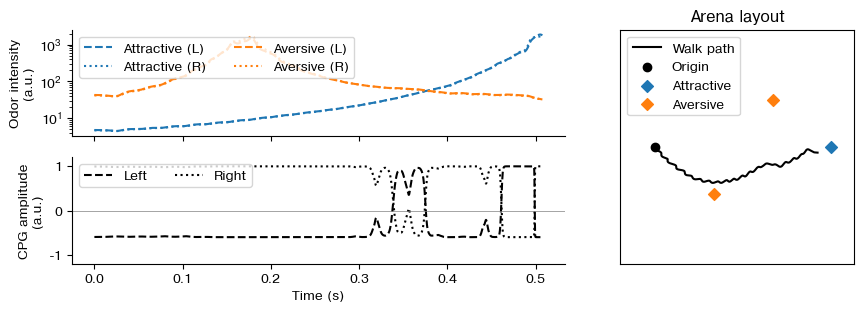

In [5]:
timestep = 1e-4
runtime = 2
num_steps = int(runtime / timestep)
fly_pos = np.array([obs["fly"] for obs in obs_list])[:, 0, :]
fly_orient = np.array([obs["fly"] for obs in obs_list])[:, 2, :]
odor = np.array([obs["odor_intensity"] for obs in obs_list])
cpg_amp = np.array(control_list)

axd = plt.figure(constrained_layout=True, figsize=(9, 3)).subplot_mosaic(
    """
    AAACC
    BBBCC
    """
)
t = np.arange(num_steps) * timestep
t = t[:odor.shape[0]]

ax = axd["A"]
ax.plot(t, odor[:, 0, 0], linestyle="--", color="tab:blue", label="Attractive (L)")
ax.plot(t, odor[:, 0, 1], linestyle=":", color="tab:blue", label="Attractive (R)")
ax.plot(t, odor[:, 1, 0], linestyle="--", color="tab:orange", label="Aversive (L)")
ax.plot(t, odor[:, 1, 1], linestyle=":", color="tab:orange", label="Aversive (R)")
ax.semilogy()
ax.legend(loc="upper left", ncols=2)
ax.set_ylabel("Odor intensity\n(a.u.)")
ax.set_xticklabels([])
sns.despine(ax=ax)

ax = axd["B"]
ax.plot(t, cpg_amp[:, 0], linestyle="--", color="black", label="Left")
ax.plot(t, cpg_amp[:, 1], linestyle=":", color="black", label="Right")
ax.axhline(0, linestyle="-", color="gray", linewidth=0.5)
ax.set_ylim([-1.2, 1.2])
ax.legend(loc="upper left", ncols=2)
ax.set_ylabel("CPG amplitude\n(a.u.)")
ax.set_xlabel("Time (s)")
sns.despine(ax=ax)

ax = axd["C"]
ax.plot(fly_pos[:, 0], fly_pos[:, 1], color="black", label="Walk path")
ax.scatter([0], [0], marker="o", color="black", label="Origin")
ax.scatter(
    [odor_source[0][0]],
    [odor_source[0][1]],
    color="tab:blue",
    marker="D",
    label="Attractive",
)
ax.scatter(
    [odor_source[1][0], odor_source[2][0]],
    [odor_source[1][1], odor_source[2][1]],
    color="tab:orange",
    marker="D",
    label="Aversive",
)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc="upper left")
ax.set_xlim([-3, 17])
ax.set_ylim([-10, 10])
ax.set_aspect("equal")
ax.set_title("Arena layout")

plt.savefig("outputs/odor_taxis_test.pdf")
plt.savefig("outputs/odor_taxis_test.png", dpi=300)

## Simulate 10 trials with random spawn locations

In [6]:
num_trials = 10
spawn_pos_xrange = [-3, 7]
spawn_pos_yrange = [-5, 5]
spawn_orient_range = [- np.pi / 2, np.pi / 2]

In [7]:
np.random.seed(0)
all_results = []
for i in range(num_trials):
    print(f"Running trial {i}")
    x = np.random.uniform(*spawn_pos_xrange)
    y = np.random.uniform(*spawn_pos_yrange)
    orientation = np.random.uniform(*spawn_orient_range)
    res = run_trial(
        spawn_pos=(x, y, 0.5),
        spawn_orientation=[0, 0, 1, orientation],
        odor_source=odor_source,
        peak_intensity=peak_intensity,
        video_path=f"outputs/odor_taxis_{i}.mp4",
    )
    all_results.append(res)

Running trial 0


 28%|██▊       | 5580/20000 [00:09<00:24, 591.59it/s]


Running trial 1


 23%|██▎       | 4689/20000 [00:07<00:26, 587.10it/s]


Running trial 2


 26%|██▋       | 5298/20000 [00:08<00:24, 591.13it/s]


Running trial 3


 28%|██▊       | 5615/20000 [00:09<00:24, 590.89it/s]


Running trial 4


 23%|██▎       | 4672/20000 [00:08<00:26, 569.20it/s]


Running trial 5


 25%|██▍       | 4948/20000 [00:08<00:25, 580.98it/s]


Running trial 6


 33%|███▎      | 6685/20000 [00:11<00:23, 578.48it/s]


Running trial 7


100%|██████████| 20000/20000 [00:33<00:00, 591.31it/s]


Running trial 8


 18%|█▊        | 3647/20000 [00:06<00:29, 563.44it/s]


Running trial 9


 25%|██▌       | 5087/20000 [00:08<00:26, 568.64it/s]


In [10]:
trajectories = []
target_found = []
for obs_list, control_list in all_results:
    trajectory = np.array([obs["fly"] for obs in obs_list])[:, 0, :]
    trajectories.append(trajectory)
    is_found = euclidean(trajectory[-1, :2], odor_source[0][:2]) < 5
    target_found.append(is_found)

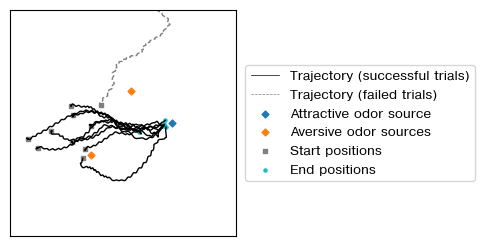

In [11]:
plt.figure(figsize=(5, 5))
for trajectory, is_found in zip(trajectories, target_found):
    if is_found:
        line_color = "black"
        linestyle = "-"
    else:
        line_color = "tab:gray"
        linestyle = "--"
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=line_color, linestyle=linestyle, linewidth=1)
    plt.scatter([trajectory[0, 0]], [trajectory[0, 1]], marker="s", color="gray", s=5)
    if is_found:
        plt.scatter([trajectory[-1, 0]], [trajectory[-1, 1]], marker="o", color="tab:cyan", s=5)
plt.plot([], [], color="black", linestyle="-", linewidth=0.5, label="Trajectory (successful trials)")
plt.plot([], [], color="tab:gray", linestyle="--", linewidth=0.5, label="Trajectory (failed trials)")
plt.scatter(
    [odor_source[0][0]],
    [odor_source[0][1]],
    color="tab:blue",
    marker="D",
    label="Attractive odor source",
    s=12,
)
plt.scatter(
    [odor_source[1][0], odor_source[2][0]],
    [odor_source[1][1], odor_source[2][1]],
    color="tab:orange",
    marker="D",
    label="Aversive odor sources",
    s=12,
)
plt.scatter([], [], marker="s", color="gray", s=5, label="Start positions")
plt.scatter([], [], marker="o", color="tab:cyan", s=5, label="End positions")
plt.gca().set_aspect("equal")
plt.xlim([-5, 23])
plt.ylim([-14, 14])
plt.xticks([])
plt.yticks([])
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.tight_layout()
plt.savefig("outputs/trajectories_all_trials.pdf")